# 6.2 Exploring relationships

### This script contains the following:

### 1. Importing Data and Visualization Libraries
### 2. Exploring Relationships

### 1. Importing Data and Visualization Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
# Define path for easier data import
path = r'C:\Users\magia\NY CitiBike\2. Data\Prepared Data'

In [3]:
# Importing data
df = pd.read_csv(os.path.join(path, 'citibike_cleaned.csv'))

### 2. Data Preparation for Visualizations

In [4]:
df.columns

Index(['bike_id', 'weekday', 'start_hour', 'start_time', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_time', 'end_station_id',
       'end_station_name', 'end_station_latitude', 'end_station_longitude',
       'trip_duration', 'subscriber', 'birth_year', 'gender',
       'birth_year_label', '88+_years_old'],
      dtype='object')

In [5]:
# Mapping weekday strings to integers
weekday_map = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

df['weekday'] = df['weekday'].map(weekday_map)

In [6]:
# Converting start_time and end_time to datetatime type
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce')

In [7]:
# Extracting numeric fields for analysis from start_time
df['start_hour'] = df['start_time'].dt.hour
df['start_day'] = df['start_time'].dt.day
df['start_month'] = df['start_time'].dt.month
df['start_year'] = df['start_time'].dt.year
df['start_weekday'] = df['start_time'].dt.weekday + 1  #1=Monday, ..., 7=Sunday

### 3. Exploring Relationships

In [8]:
df.dtypes

bike_id                             int64
weekday                           float64
start_hour                          int32
start_time                 datetime64[ns]
start_station_id                    int64
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_time                   datetime64[ns]
end_station_id                      int64
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
trip_duration                       int64
subscriber                         object
birth_year                        float64
gender                             object
birth_year_label                   object
88+_years_old                        bool
start_day                           int32
start_month                         int32
start_year                          int32
start_weekday                       int32
dtype: object

In [9]:
# Selecting numeric columns for correlation matrix
numeric_df = df.select_dtypes(include='number') 
corr_matrix = numeric_df.corr()

#### Creating subscriber_id and gender_id columns to use in correlation analysis

In [10]:
# Map subscriber status to binary numeric ID
df['subscriber_id'] = df['subscriber'].map({'Subscriber': 1, 'Non-Subscriber': 0})

# Map gender to numeric ID: Female = 2, Male = 1, Unknown = 0
df['gender_id'] = df['gender'].map({'Female': 2, 'Male': 1, 'Unknown': 0})

In [11]:
# Create df subset with columns of interest for correlation analysis
columns_of_interest = [
    'start_weekday',     # previously created from start_time
    'trip_duration',
    'start_hour',
    'birth_year',
    'start_station_id',
    'bike_id',
    'subscriber_id',
    'gender_id'
]

df_subset = df[columns_of_interest]

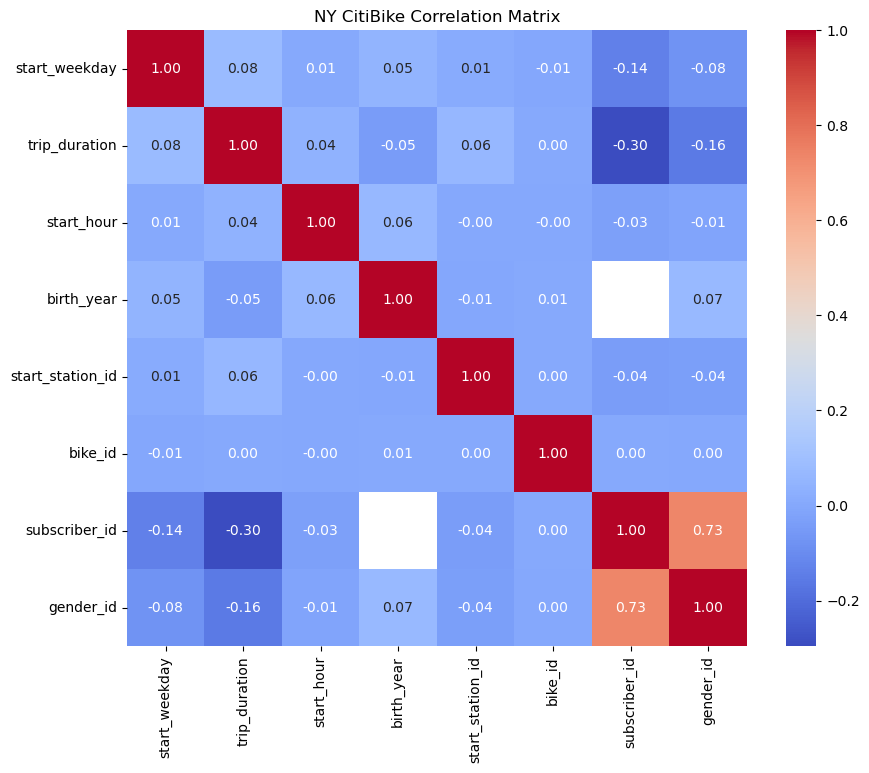

In [12]:
# Generate a correlation matrix

plt.figure(figsize=(10, 8))
sns.heatmap(df_subset.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("NY CitiBike Correlation Matrix")
plt.show()

We observe a strong correlation (0.73) between gender_id and subscriber_id. The labels are: 0 = Unknown, 1 = Male, and 2 = Female, which at first glance might suggest that more women tend to be subscribers than men. However, since 14% of our data comes from users who are both non-subscribers and have unknown gender, this **likely inflates** the correlation. 

For the rest of the variables, correlation levels are low, all below 0.1. 

The next strongest correlation is -0.3 between **subscriber_id and trip_duration**. Given that 0 = Non-Subscriber and 1 = Subscriber, this negative correlation suggests that, to some extent, non-subscribers tend to have longer trips than subscribers — perhaps due to different usage patterns, such as tourists versus commuters.

#### Plotting the gender_id vs subscriber_id relationship

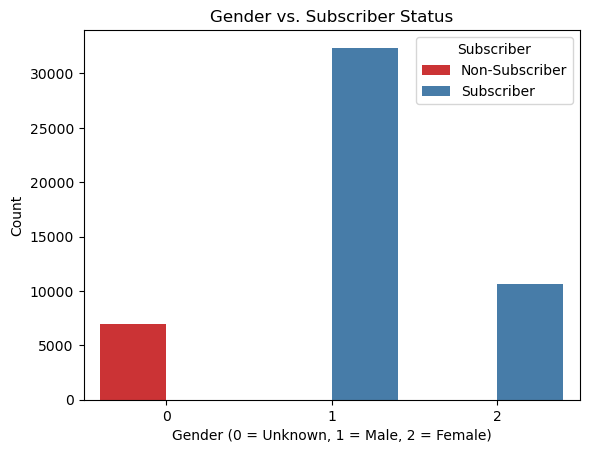

In [13]:
# Creating chart plotting gender and subscriber status relationship
sns.countplot(data=df, x='gender_id', hue='subscriber_id', palette = 'Set1')
plt.title("Gender vs. Subscriber Status")
plt.xlabel("Gender (0 = Unknown, 1 = Male, 2 = Female)")
plt.ylabel("Count")
plt.legend(title='Subscriber', labels=['Non-Subscriber', 'Subscriber'])
plt.show()

The strong correlation (~0.73) between subscriber_id and gender_id is *not about gender preferences*, but rather: A structural feature of the dataset — only subscribers have gender data. This is a data artifact, **not a behavioral insight**.

#### Plotting the trip_duration vs. subscriber_id relationship

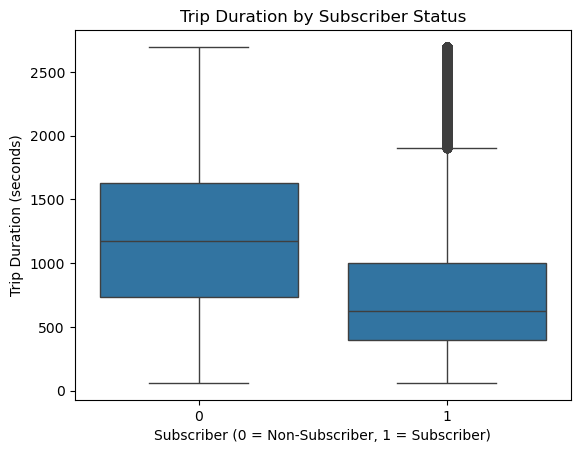

In [14]:
# Creating box plot for trip_duration and subscriber status

sns.boxplot(x='subscriber_id', y='trip_duration', data=df)
plt.title("Trip Duration by Subscriber Status")
plt.xlabel("Subscriber (0 = Non-Subscriber, 1 = Subscriber)")
plt.ylabel("Trip Duration (seconds)")

plt.show()

- The box plot shows that non-subscribers tend to have longer trip durations compared to subscribers, with medians around 15 and 10 minutes, respectively. 
- However, we do have outliers in the case of subscribers only, who have particularly long trips of 30-40minutes (between 2000-2500 seconds).

#### Plotting the start_station_id vs. start_hour relationship

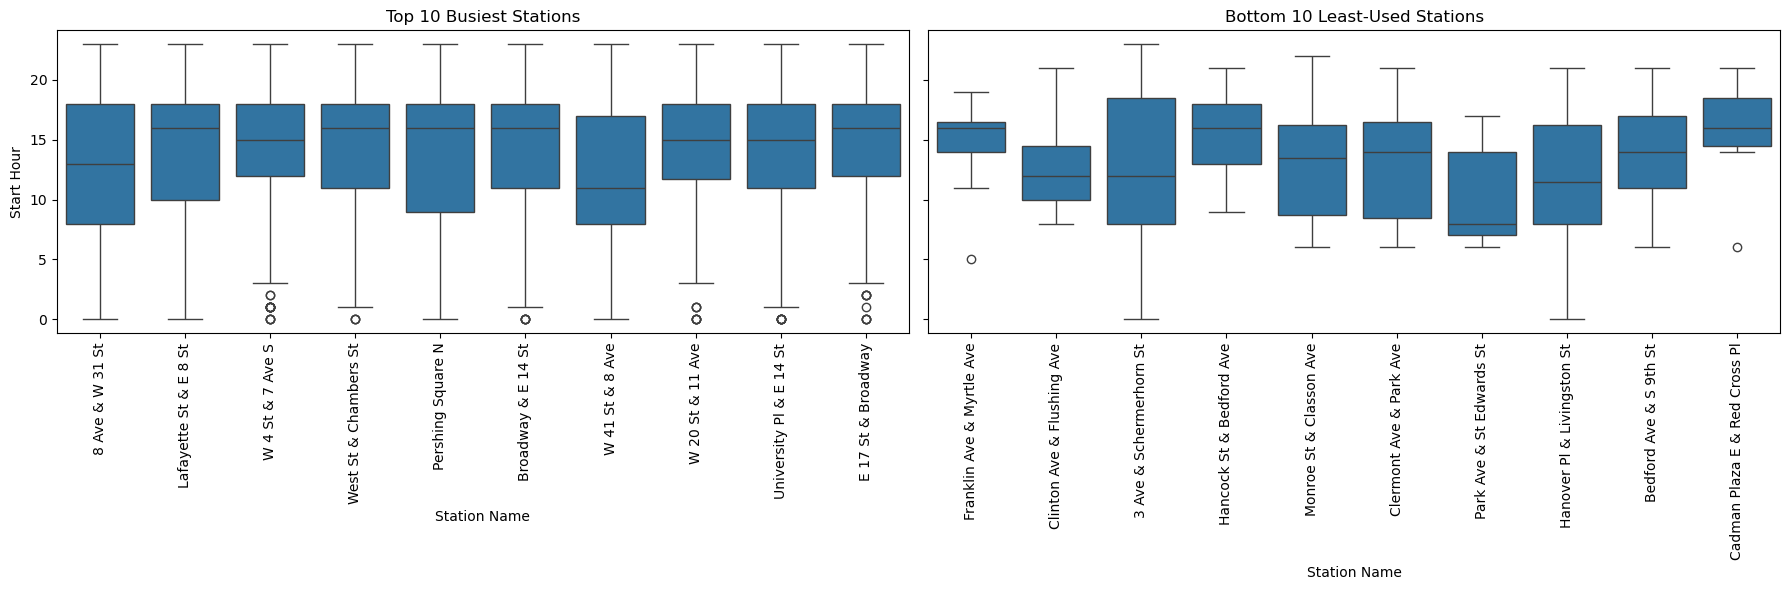

In [15]:
# Count trips per station
station_counts = df['start_station_name'].value_counts()

# Top 10 busiest stations
top_10 = station_counts.head(10).index

# Bottom 10 least-used stations (with at least >5 uses to avoid noise)
bottom_10 = station_counts[station_counts > 5].tail(10).index

# Filter data
df_top10 = df[df['start_station_name'].isin(top_10)]
df_bottom10 = df[df['start_station_name'].isin(bottom_10)]

# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Top 10
sns.boxplot(ax=axes[0], data=df_top10, x='start_station_name', y='start_hour')
axes[0].set_title("Top 10 Busiest Stations")
axes[0].set_xlabel("Station Name")
axes[0].set_ylabel("Start Hour")
axes[0].tick_params(axis='x', rotation=90)

# Bottom 10
sns.boxplot(ax=axes[1], data=df_bottom10, x='start_station_name', y='start_hour')
axes[1].set_title("Bottom 10 Least-Used Stations")
axes[1].set_xlabel("Station Name")
axes[1].set_ylabel("Start Hour")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

- Top 10 stations (as a starting point) likely show mostly peak during rush hour (5–7 PM), suggesting they're used by daily riders getting off work. 
- Bottom 10 have more scattered usage, suggesting occasional or tourist use.

#### Plotting the end_station_id vs. start_hour relationship

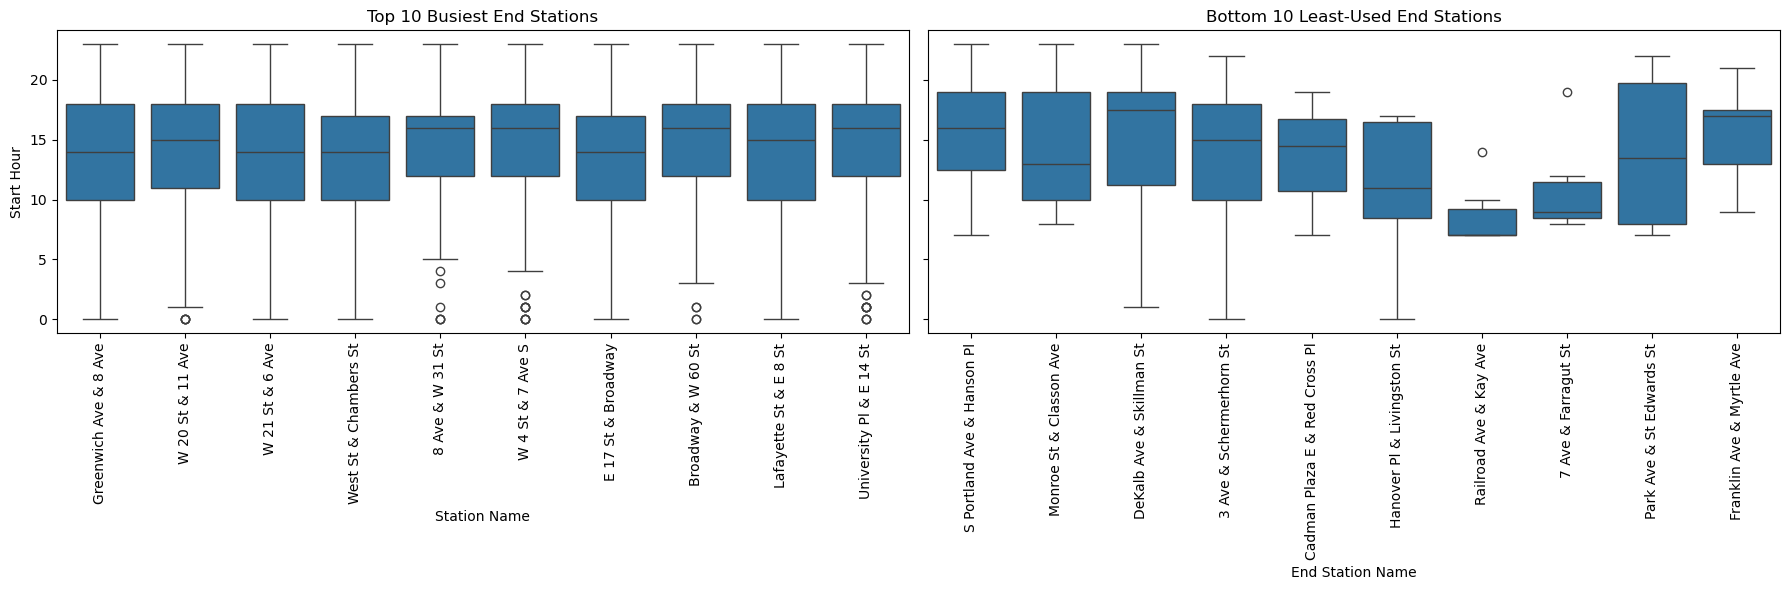

In [16]:
# Count trips per station
station_counts = df['end_station_name'].value_counts()

# Top 10 busiest stations
top_10 = station_counts.head(10).index

# Bottom 10 least-used stations (with at least >5 uses to avoid noise)
bottom_10 = station_counts[station_counts > 5].tail(10).index

# Filter data
df_top10 = df[df['end_station_name'].isin(top_10)]
df_bottom10 = df[df['end_station_name'].isin(bottom_10)]

# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Top 10
sns.boxplot(ax=axes[0], data=df_top10, x='end_station_name', y='start_hour')
axes[0].set_title("Top 10 Busiest End Stations")
axes[0].set_xlabel("Station Name")
axes[0].set_ylabel("Start Hour")
axes[0].tick_params(axis='x', rotation=90)

# Bottom 10
sns.boxplot(ax=axes[1], data=df_bottom10, x='end_station_name', y='start_hour')
axes[1].set_title("Bottom 10 Least-Used End Stations")
axes[1].set_xlabel("End Station Name")
axes[1].set_ylabel("Start Hour")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

- Top 10 stations (as an end point) mostly peak at a similar time (between 4 and 6 PM) 
- Bottom 10, like the bottom 10 least used start stations, have more scattered usage, suggesting occasional or tourist use.

#### Creating pair plot

In [17]:
# Keep only the variables you want to use in the pair plot

sub_2 = df[['start_day', 'trip_duration', 'birth_year', 'start_station_id', 'gender_id', 'end_station_id', 'start_hour']]

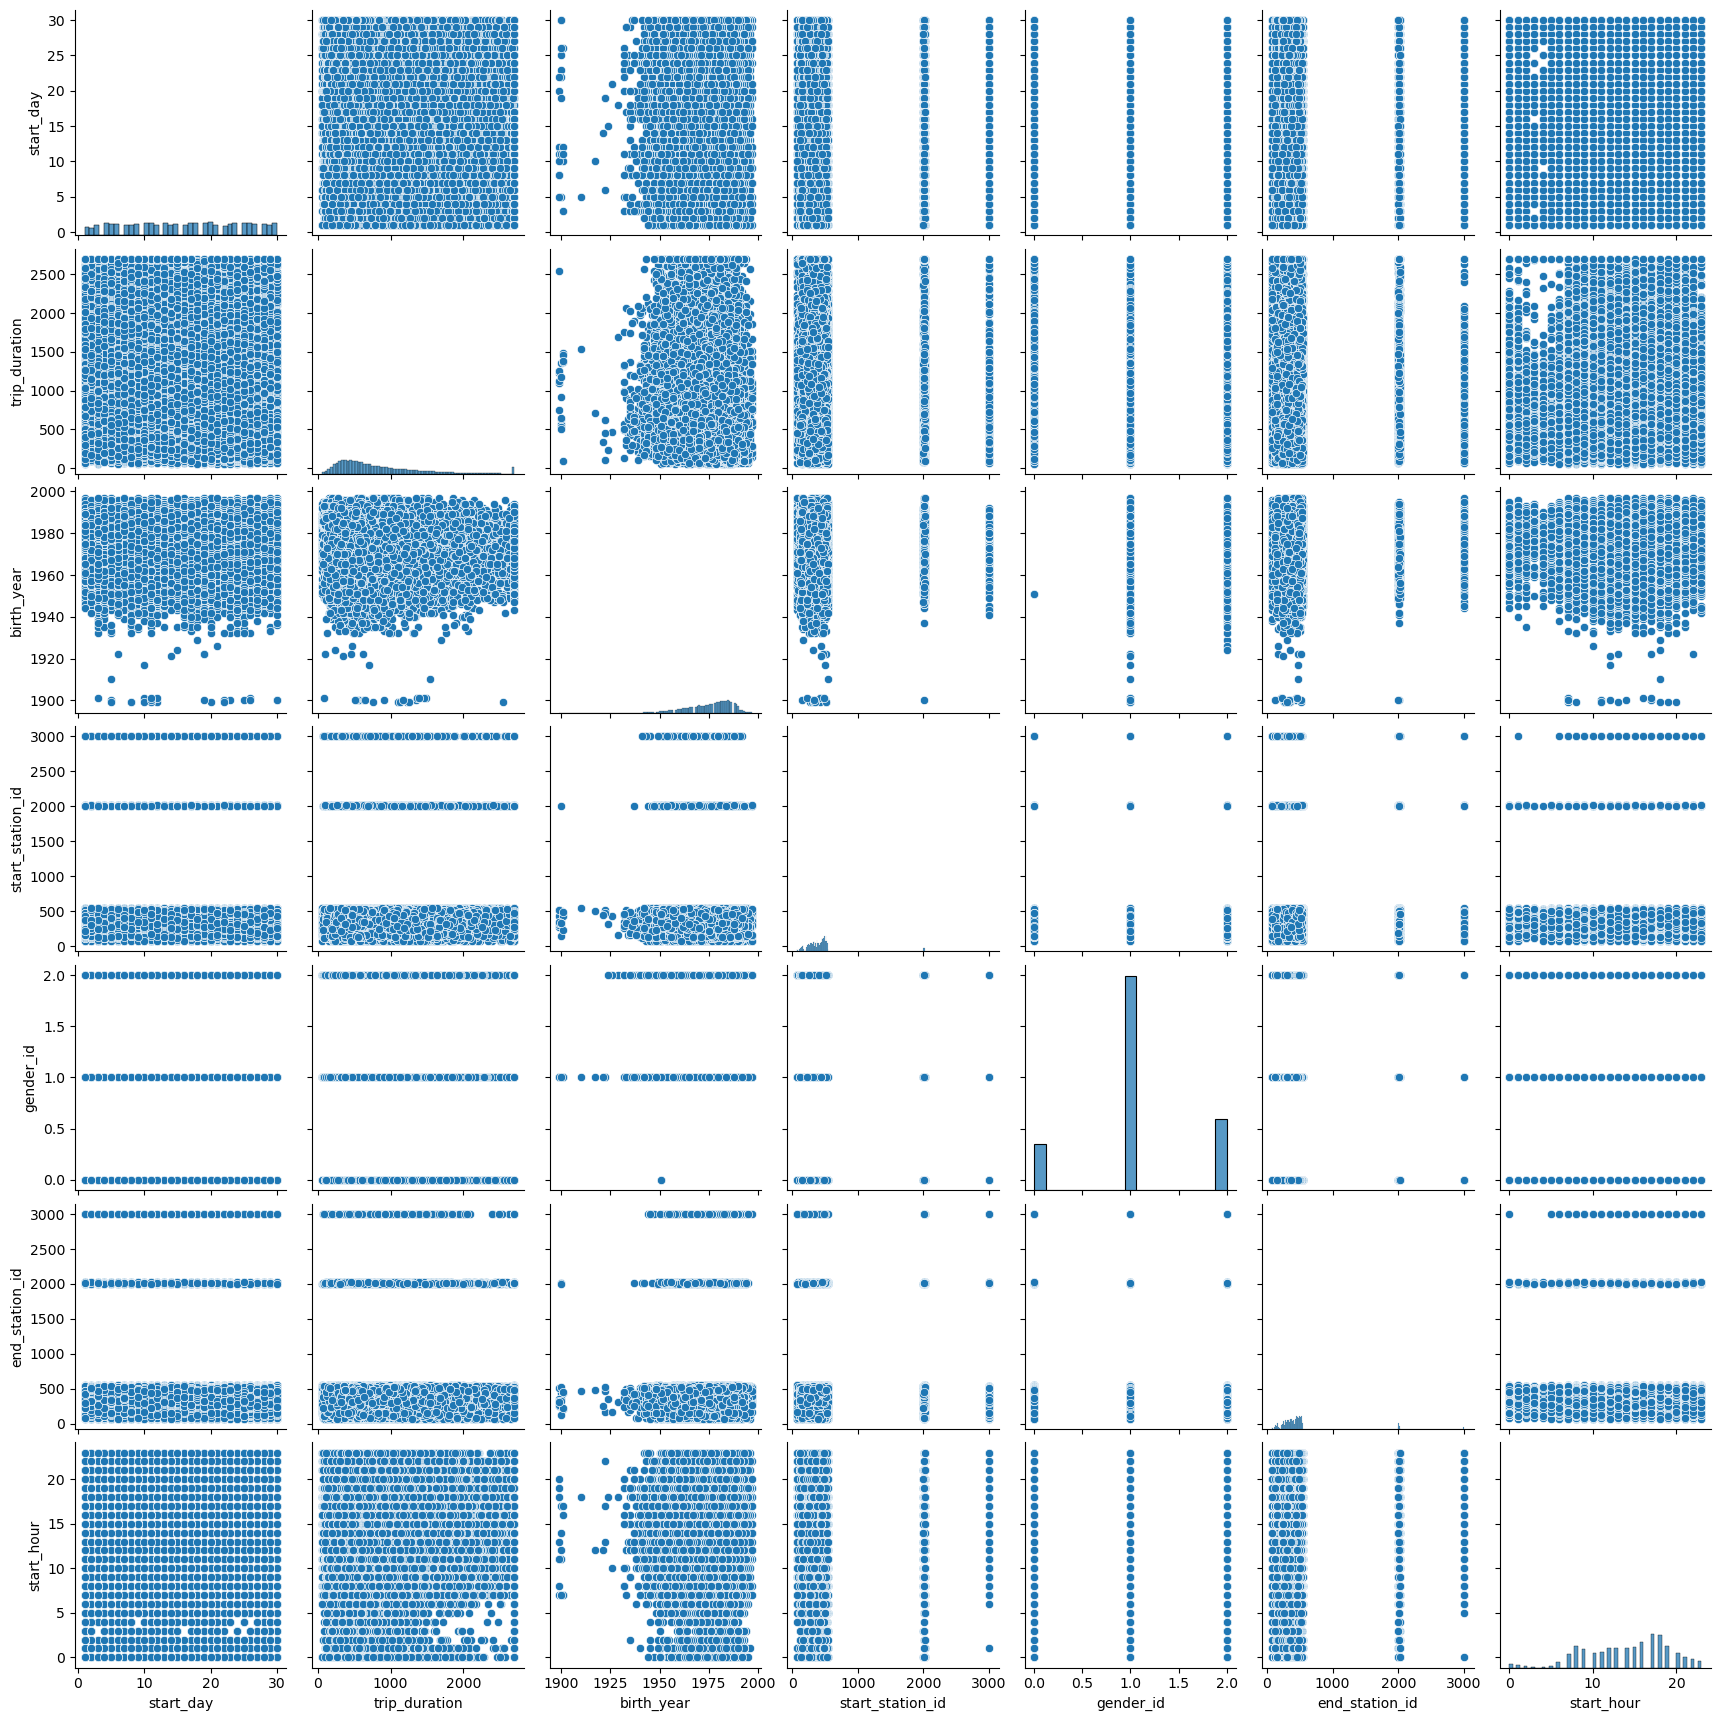

In [18]:
# Creating pair plot
g = sns.pairplot(sub_2)

- Birth Year & Gender ID: Outliers born between 1900–1925 are predominantly male.

- Start Hour & Day of Month: Fewer trips are recorded in the early morning hours (00:00–06:00), especially on certain days of the month.

- Start Station ID: Stations with IDs under 1000 appear to have the highest traffic.

- Trip Duration & Start Hour: Trips of all durations occur throughout the day, though long trips are rare during the night and early morning (00:00–06:00).

#### Creating categorical plot

<Axes: xlabel='trip_duration', ylabel='Count'>

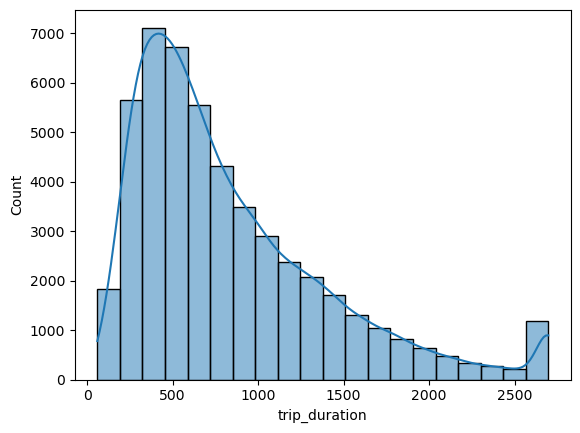

In [19]:
# Use a histogram to visualize the distribution of the variable trip_duration
sns.histplot(df['trip_duration'], bins = 20, kde = True)

The histogram shows that most trips last between 400 and 700 seconds (approximately 7 to 10 minutes). Fewer trips are shorter, and a smaller but notable number of trips are longer in duration.

#### Recap

Q2: Relationship between age and trip duration, by user type
Non-subscribers tend to have longer trip durations. Median trip durations are ~10 mins for subscribers and ~15 mins for non-subscribers. 
Age and trip duration seem not to be correlated at this point (we have few data points and these might be mistakes).

Q5: Most frequently used stations
We could answer this only in part. We found that start stations with IDs < 1000 are more used. We will analyze end stations as well to fully understand overall station popularity.

Q6: Usage by weekday & hour
Early morning (00–06) has the least usage. Also long trips are uncommon in these hours. Weekdays were not fully explored, as the pair plot was too busy to allow us to confirm that the less busy days were a particular day, or random days during the month of September. 

The other questions (such as age vs. usage time, geographic distribution by age group, distance calculations, and station-to-station flows) require additional analysis and are still open.